### Code reviewer

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen-2.5-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 30, 'total_tokens': 40, 'completion_time': 0.05, 'prompt_time': 0.003688483, 'queue_time': 0.2362756, 'total_time': 0.053688483}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-0238295a-b5a6-4eeb-b2f3-1f2afbb876f3-0', usage_metadata={'input_tokens': 30, 'output_tokens': 10, 'total_tokens': 40})

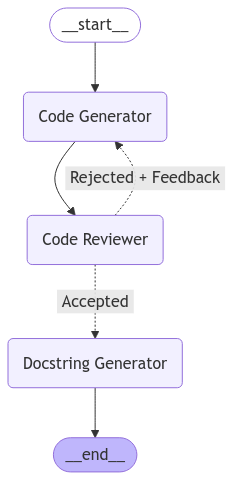

In [15]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage

# Graph state
class State(TypedDict):
    code: str
    requirement: str
    feedback: str
    correct_or_not: str
    docstring: str

# Schema for structured output to use in review
class Feedback(BaseModel):
    review: Literal["correct", "not correct"] = Field(
        description="Decide if the code is correct as per requirement or not.",
    )
    feedback: str = Field(
        description="If the code is not as per requirement, provide feedback.",
    )

# Augment the LLM with schema for structured output
reviewer = llm.with_structured_output(Feedback)

# Nodes
def llm_code_generator(state: State):
    """LLM generates code"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a code for the requirement: {state['requirement']} but take into account the feedback: {state['feedback']}, No preambles."
        )
    else:
        msg = llm.invoke(f"Write a code for the requirement {state['requirement']}, No preambles.")
    return {"code": msg.content}

def llm_code_reviewer(state: State):
    """LLM reviews code"""

    feedback = reviewer.invoke(f"Review the code {state['code']} for the requirement {state['requirement']}")
    return {"correct_or_not": feedback.review, "feedback": feedback.feedback}

def llm_docstring_generator(state: State):
    """LLM generates doctring for the code in markdowm format"""

    docString = llm.invoke(f"Generate the Doc string for the code {state['code']} in markdown format")
    #print("Doctring: ", docString.content)
    return {"docstring": docString.content}

# Conditional edge function to route back to code generator or end based upon feedback from the reviewer
def route_code(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["correct_or_not"] == "correct":
        return "Accepted"
    elif state["correct_or_not"] == "not correct":
        return "Rejected + Feedback"

# Build workflow
reviewer_builder = StateGraph(State)

#Add the nodes
reviewer_builder.add_node("Code Generator", llm_code_generator)
reviewer_builder.add_node("Code Reviewer", llm_code_reviewer)
reviewer_builder.add_node("Docstring Generator", llm_docstring_generator)

# Add edges to connect nodes
reviewer_builder.add_edge(START, "Code Generator")
reviewer_builder.add_edge("Code Generator", "Code Reviewer")
reviewer_builder.add_conditional_edges("Code Reviewer", route_code,
    {
        "Accepted": "Docstring Generator",
        "Rejected + Feedback": "Code Generator"
    }
)

reviewer_builder.add_edge("Docstring Generator", END)

reviewer_workflow = reviewer_builder.compile()

# Show the workflow
display(Image(reviewer_workflow.get_graph().draw_mermaid_png()))

In [17]:
# Invoke
state = reviewer_workflow.invoke({"requirement": "Write a code for adding two numbers"})
print(state["code"])
print("------------------------")
print(state["docstring"])

```python
def add_two_numbers(a, b):
    return a + b

result = add_two_numbers(3, 5)
print(result)
```
------------------------
Here is the docstring for the provided Python code in markdown format:

```markdown
## Function: `add_two_numbers`

- **Description**: This function takes two numbers as input and returns their sum.
- **Parameters**:
  - `a`: The first number to be added.
  - `b`: The second number to be added.
- **Returns**: The sum of `a` and `b`.

## Usage Example

```python
result = add_two_numbers(3, 5)
print(result)  # Output will be 8
```
```
